In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import tensorflow as tf

In [3]:
#******************************************
# Data import
#******************************************

# import train, dev and test datasets: the data entries are all strings of the form 'label sentence' 
# with the label in {0,1} and with the sentence of the form "word1_POStag1 word2_POStag2 ..."

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_train_data.txt') as f:
    training_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_dev_data.txt') as f:
    dev_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_test_data.txt') as f:
    testing_data_raw = f.readlines()

In [4]:
#***************************************************************
# Turn the raw input data into data structures convenient below
#***************************************************************

vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data = []       # list of sentences in the test dataset as strings "word1 word2 ..."
training_data_label = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data_label = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data_label = []
# Go through the train data
for sent in training_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    training_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    training_data_label.append(label)

# Go through the dev data
for sent in dev_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    dev_data_label.append(label)
    
# Go through the test data
for sent in testing_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    testing_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    testing_data_label.append(label)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

def embedding_sentece(data_list):
    sentences = data_list
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)  
    word_index = tokenizer.word_index  
    vocab_size = len(word_index) + 1  # Số lượng từ vựng (+1 cho padding)
    sequences = tokenizer.texts_to_sequences(sentences)

    max_length = max(len(seq) for seq in sequences)  # Độ dài tối đa
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    
    embedding_dim = 4  # Chọn số chiều của vector embedding
    
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
    ])
    
    output = model.predict(padded_sequences)
    return output
X = np.array(embedding_sentece(training_data), dtype='float64')
Y = np.array(training_data_label)
X_dev = np.array(embedding_sentece(dev_data), dtype='float64')
Y_dev = np.array(dev_data_label)
X_test = np.array(embedding_sentece(testing_data), dtype='float64')
Y_test = np.array(testing_data_label)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


In [6]:
X = X.reshape(-1,16)
X_dev = X_dev.reshape(-1,16)
X_test = X_test.reshape(-1,16)

In [7]:
def state_preparation(x):
    qml.AmplitudeEmbedding(features=x, wires=[0,1,2,3], normalize=True)
    qml.AmplitudeEmbedding(features=x, wires=[4,5,6,7], normalize=True)
    qml.AmplitudeEmbedding(features=x, wires=[8,9,10,11], normalize=True)

In [8]:
def blue_block(weights, wires1, wires2):
    '''
    weights length = 6
    '''
    qml.RZ(weights[0],wires=wires1)
    qml.RY(weights[1],wires=wires1)
    qml.RZ(weights[2],wires=wires1)
    qml.RZ(weights[3],wires=wires2)
    qml.RY(weights[4],wires=wires2)
    qml.RZ(weights[5],wires=wires2)
    qml.CNOT(wires=[wires1,wires2])
    qml.CNOT(wires=[wires2,wires1])
def orange_block(weights,wires1, wires2):
    '''
    weights length = 16
    '''
    # yellow block
    qml.RZ(weights[0],wires=wires1)
    qml.RY(weights[1],wires=wires1)
    qml.RZ(weights[2],wires=wires1)
    qml.RZ(weights[3],wires=wires2)
    qml.RY(weights[4],wires=wires2)
    qml.RZ(weights[6],wires=wires2)
    # white block
    qml.CNOT(wires=[wires2,wires1])
    qml.RZ(weights[7],wires=wires1)
    qml.RY(weights[8],wires=wires2)
    qml.CNOT(wires=[wires1,wires2])
    qml.RY(weights[9],wires=wires2)
    qml.CNOT(wires=[wires2,wires1])
    # yellow block
    qml.RZ(weights[10],wires=wires1)
    qml.RY(weights[11],wires=wires1)
    qml.RZ(weights[12],wires=wires1)
    qml.RZ(weights[13],wires=wires2)
    qml.RY(weights[14],wires=wires2)
    qml.RZ(weights[15],wires=wires2)
    

In [9]:
# weights = np.random.random(size=[16])
# print(qml.draw(orange_block)(weights,0,1))

In [10]:
weights = np.random.random(size=[32,16], requires_grad=True)
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
parameters = np.random.random(size=shape, requires_grad=True)

In [11]:
weights.shape

(32, 16)

In [12]:
parameters.shape

(2, 4, 3)

In [13]:
dev = qml.device('default.qubit', wires=12)
@qml.qnode(dev)
def full_circuit(weights, parameters,x):
    '''
    Q: 16 blue
    Q_1: 4 blue
    Q_2: 4 blue
    Q_3: 4 blue
    Q_4: 4 blue
    K: 16 blue, 16 orange
    K_1: 4 orange
    ...
    K_4: 4 orange
    V: 4 4 4 4 orange = 16 orange
    Sum: 16 blue, 16 orange = 32 total 
    32x16
    weigths = (weights, parameter)
    '''
    state_preparation(x)
    index = 0
    # blue block
    for i in range(4):
        wiresq = i
        for j in range(4):
            wiresk = j+4
            weight = weights[index]
            index += 1
            blue_block(weight, wiresq, wiresk)
            weight = weights[index]
            index += 1
            wiresv = wiresk+4
            orange_block(weight, wiresk, wiresv)
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(8,12))
    observable = qml.PauliZ(11)
    return qml.expval(observable)

In [14]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc
def cost(weights,parameters, X, Y):
    predictions = [full_circuit(x=x, weights=weights,parameters=parameters) for x in X]
    return square_loss(Y, predictions)

In [15]:
lrate = 0.5
opt = NesterovMomentumOptimizer(lrate)

In [16]:
import matplotlib.pyplot as plt
def draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers=1):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    axs[0].plot(epoch, current_cost_list,label=f'loss_{lrate}')
    axs[0].set_title(f'Loss {n_layers}')
    axs[0].set_xlabel('Epoch')  # Set x-axis label
    axs[0].set_ylabel('Cost Function')  # Set y-axis label
    axs[0].legend()
    axs[1].plot(epoch, acc_list, label=f'train_acc_{lrate}')
    axs[1].set_title(f'Train acc {n_layers}')
    axs[1].set_xlabel('Epoch')  # Set x-axis label
    axs[1].set_ylabel('Train Accuraccy')  # Set y-axis label
    axs[1].legend()
    axs[2].plot(epoch, test_acc_list,label=f'test_acc_{lrate}')
    axs[2].set_title(f'Test acc {n_layers}')
    axs[2].set_xlabel('Epoch')  # Set x-axis label
    axs[2].set_ylabel('Test Accuraccy')  # Set y-axis label
    axs[2].legend()
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"/kaggle/working/chart_nlayer{n_layers}_lrate{lrate}.png")

Iter:    1 | Cost: 0.9808540 | Accuracy: 0.6714286 | Test Accuracy: 0.4000000
Iter:    2 | Cost: 0.9732410 | Accuracy: 0.7142857 | Test Accuracy: 0.5000000
Iter:    3 | Cost: 0.9634055 | Accuracy: 0.7428571 | Test Accuracy: 0.4666667
Iter:    4 | Cost: 0.9528119 | Accuracy: 0.7857143 | Test Accuracy: 0.5333333
Iter:    5 | Cost: 0.9427419 | Accuracy: 0.8285714 | Test Accuracy: 0.5666667
Iter:    6 | Cost: 0.9338146 | Accuracy: 0.8571429 | Test Accuracy: 0.5333333
Iter:    7 | Cost: 0.9259303 | Accuracy: 0.8857143 | Test Accuracy: 0.5000000
Iter:    8 | Cost: 0.9186283 | Accuracy: 0.8857143 | Test Accuracy: 0.5000000
Iter:    9 | Cost: 0.9115251 | Accuracy: 0.9000000 | Test Accuracy: 0.5000000
Iter:   10 | Cost: 0.9045414 | Accuracy: 0.8714286 | Test Accuracy: 0.4666667
Iter:   11 | Cost: 0.8978395 | Accuracy: 0.8714286 | Test Accuracy: 0.4666667
Iter:   12 | Cost: 0.8915998 | Accuracy: 0.8857143 | Test Accuracy: 0.4666667
Iter:   13 | Cost: 0.8858595 | Accuracy: 0.9000000 | Test Accura

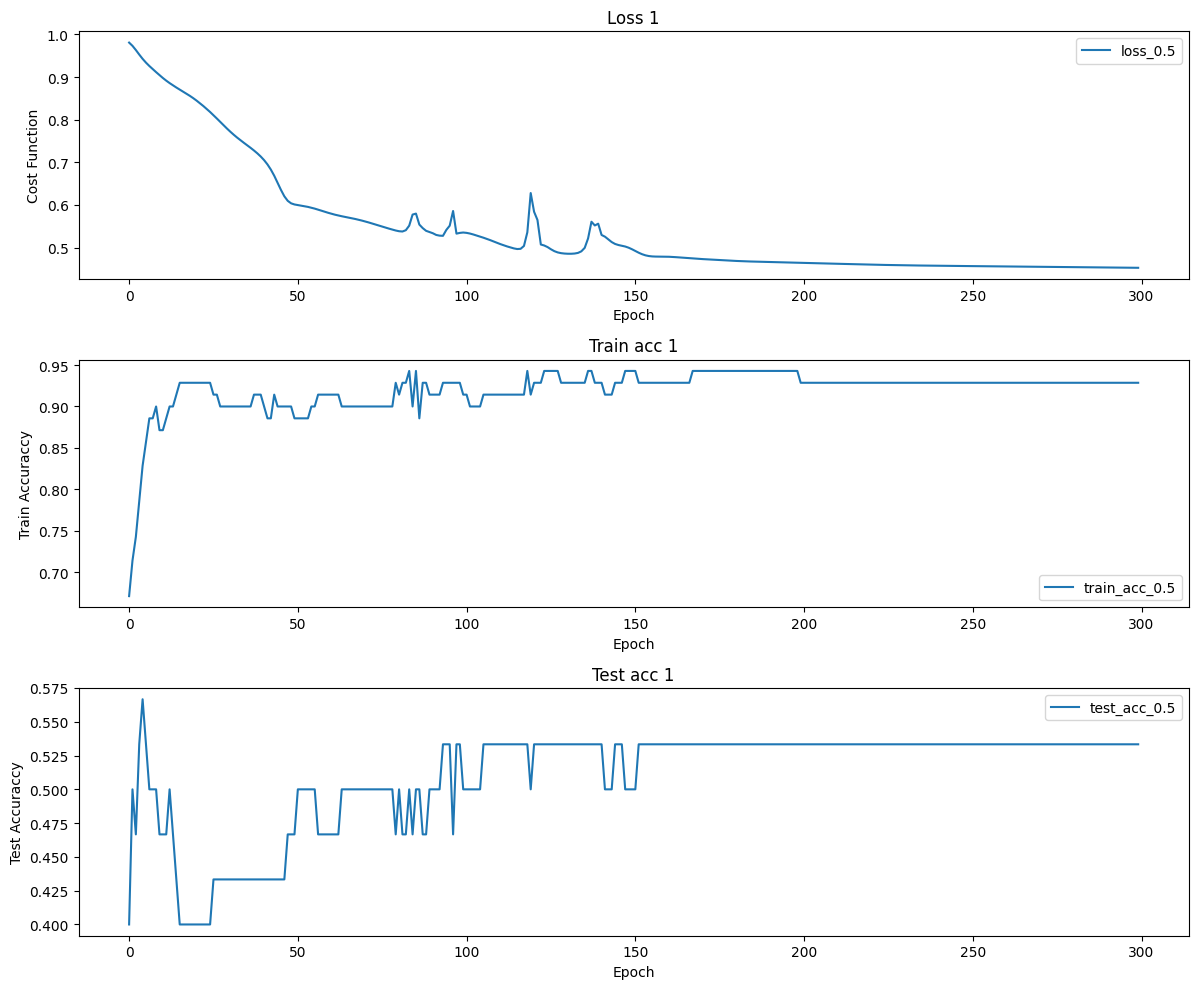

[[-1.16934163e-01  8.31559894e-01  3.78857147e-01  5.17353167e-01
   1.19274069e+00  4.25894842e-01  9.03577728e-01  8.53819201e-01
   1.56268021e-01  7.15367250e-01  9.74304729e-01  2.05300831e-01
   9.96825599e-01  9.30552950e-01  5.51576423e-01  8.93686042e-01]
 [-6.50628759e-02  1.05306239e+00  1.62035834e-01  5.23525751e-01
  -1.27246119e-01  3.48671298e-01  1.06528574e+00  5.13175800e-03
  -9.34424658e-04 -9.06294531e-03  1.31655238e+00  3.28790677e-01
   1.33051816e+00 -4.18994182e-01  3.18879740e-01  1.00779935e-02]
 [ 1.87998356e-01  1.55813809e+00  4.65876027e-02  2.11916890e-01
  -4.26924414e-01 -5.99719712e-01  9.05709624e-01  9.94312147e-01
   5.22651746e-02  9.72957384e-01  8.66323973e-01  7.62548341e-01
   9.46366599e-01  1.02613412e-01  5.81357317e-01  6.88718622e-01]
 [ 7.30739788e-01  5.50100195e-01  1.11344303e-01  7.47777378e-01
   1.00043487e+00  4.46015818e-01  3.00312663e-01 -2.05587238e-03
   1.16249129e-03  1.61524948e-03  5.02742807e-01  7.72981297e-01
   3.88

In [17]:
current_cost_list = []
acc_list = []
test_acc_list = []
epoch = []
for it in range(300):
    # Update the weights by one optimizer step, using only a limited batch of data
    weights,parameters = opt.step(cost, weights,parameters, X=X, Y=Y)
    # Compute accuracy
    predictions = [np.sign(full_circuit(x=x,weights=weights,parameters=parameters)) for x in X]
    current_cost = cost(weights,parameters=parameters, X=X, Y=Y)
    current_cost_list.append(current_cost)
    acc = accuracy(Y, predictions)
    
    acc_list.append(acc)
    # compute on dev set
    predictions_test = [np.sign(full_circuit(x=x,weights=weights,parameters=parameters)) for x in X_dev]
    test_acc = accuracy(Y_dev, predictions)
    test_acc_list.append(test_acc)
    epoch.append(it)
    # Redraw the updated plot
    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f} | Test Accuracy: {test_acc:0.7f}")   
draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate)
print(weights)

In [18]:
# Compute accuracy
predictions = [np.sign(full_circuit(x=x,weights=weights,parameters=parameters)) for x in X_test]

current_cost = cost(weights,parameters,i, X_test, Y_test)
acc = accuracy(Y_test, predictions)
print(f"Final test, accuracy_test: {acc}")

NameError: name 'i' is not defined